# RF Signal Detection with DINOv3

This notebook explores using DINOv3 for zero-shot foreground segmentation on RF spectrograms generated from sigmf files.

In [ ]:
# CONFIGURATION SIGINT_DAY_DEMO_all_16_Emitter_noNoise
#FILE_PATH = '/home/trudes/Projects/Dinov3-RF-Signal-Detection/data/IQEngine/DJI_mavic_mini_2G.sigmf-meta'
#FILE_PATH = '/home/trudes/Projects/Dinov3-RF-Signal-Detection/data/IQEngine/DJI_inspire_2_5G.sigmf-meta'
FILE_PATH = '/home/trudes/Projects/Dinov3-RF-Signal-Detection/data/IQEngine/SIGINT_DAY_DEMO_all_16_Emitter_noNoise.sigmf-meta'
FFT_SIZE = 1024
NOVERLAP = 512
DINO_SLICE_SIZE = 1024  # if smaller than FFT_SIZE, will be clamped by available spectrogram size
SAMPLE_OFFSET_S = 0.11  # seconds into preview to start the 1024x1024 slice
PREVIEW_SECONDS_REQUESTED = 1.0
CACHE_DIR = '/tmp/spectrogram_cache'
PREVIEW_MAX_PX = 4096


## Installation and Setup

Follow the DINOv3 README to install dependencies. Assuming the environment is set up, we import the necessary libraries.

In [132]:
import os
import json
import warnings
import time
import hashlib
import zipfile
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from sklearn.decomposition import PCA
from scipy import signal

# DINOv3 setup
DINOV3_LOCATION = "/home/trudes/Projects/dinov3"  # local repo
MODEL_NAME = "dinov3_vitb16"  # Switched to ViT-B for lower memory usage
WEIGHTS_PATH = "/home/trudes/Projects/dinov3/weights/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"  # ViT-B weights

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local",
    weights=WEIGHTS_PATH,
)
model.cuda()
model.eval()


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

## Loading Sigmf Files and Generating Spectrograms

Define functions to load sigmf data and generate spectrogram images.


load_or_cache_samples: 0.01s
SigMF params: {'sample_rate': 81920000, 'datatype': 'cf32_le', 'num_channels': 1, 'center_frequency': 2000000000.0, 'sample_start': 1, 'capture_datetime': '2022-07-29T17:23:52.000000Z', 'description': 'SIGINT DAY DEMO 2021 - all 16 Emitter with no noise', 'hw': 'simulated Ettus B200mini', 'author': 'matthias.vogel@airbus.com'}
preview spectrogram: 5.23s
Estimated SNR: 0.00 dB


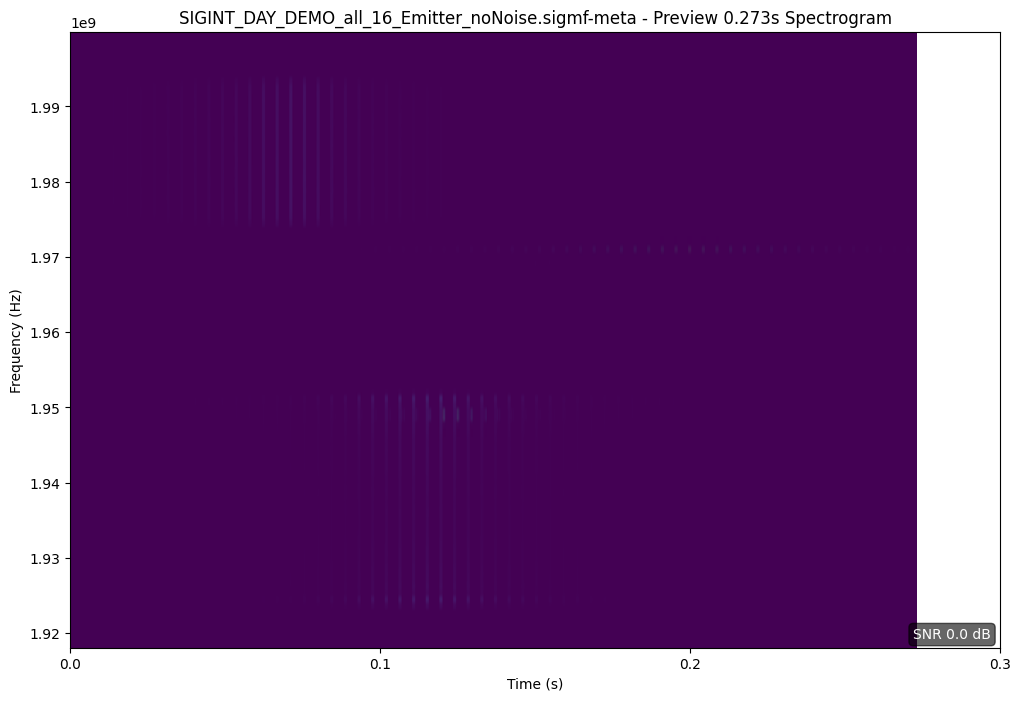

preview plot: 3.23s
Using 1024x1024 slice at y=0:1024, x=42670:43694, t0=0.266694s
dino image prep: 0.04s
Timing breakdown total: 8.53s


In [133]:
def read_sigmf_meta(meta_path):
    meta_path = Path(meta_path)
    meta = json.loads(meta_path.read_text())
    global_info = meta.get('global', {})
    captures = meta.get('captures', [])
    annotations = meta.get('annotations', [])
    return meta, global_info, captures, annotations


def _sigmf_dtype_info(datatype):
    if not datatype:
        raise ValueError('SigMF datatype is missing.')

    known = {
        'ci16_le': (np.dtype('<i2'), True),
        'ci16_be': (np.dtype('>i2'), True),
        'cf32_le': (np.dtype('<f4'), True),
        'cf32_be': (np.dtype('>f4'), True),
        'cf64_le': (np.dtype('<f8'), True),
        'cf64_be': (np.dtype('>f8'), True),
        'cu8': (np.dtype('u1'), True),
        'ci8': (np.dtype('i1'), True),
    }
    if datatype in known:
        return known[datatype]

    endian = ''
    base = datatype
    if datatype.endswith('_le'):
        endian = '<'
        base = datatype[:-3]
    elif datatype.endswith('_be'):
        endian = '>'
        base = datatype[:-3]

    is_complex = base.startswith('c')
    scalar_spec = base[1:] if is_complex else base
    if len(scalar_spec) < 2:
        raise ValueError(f'Unsupported SigMF datatype: {datatype}')

    scalar_kind = scalar_spec[0]
    bits = int(scalar_spec[1:])
    bytes_per = bits // 8

    kind_map = {'i': 'i', 'u': 'u', 'f': 'f'}
    if scalar_kind not in kind_map:
        raise ValueError(f'Unsupported SigMF datatype: {datatype}')

    dtype = np.dtype(f"{endian}{kind_map[scalar_kind]}{bytes_per}")
    return dtype, is_complex


def _load_sigmf_iq(data_path, dtype, is_complex, start_sample, count, num_channels=1, channel=0):
    data_path = Path(data_path)
    bytes_per_scalar = dtype.itemsize
    scalars_per_sample = (2 if is_complex else 1) * num_channels

    file_size = data_path.stat().st_size
    total_samples = file_size // (bytes_per_scalar * scalars_per_sample)
    if start_sample < 0 or start_sample >= total_samples:
        raise ValueError('Requested start_sample is outside the file.')

    if count is None:
        count = total_samples - start_sample
    count = min(count, total_samples - start_sample)
    if count <= 0:
        raise ValueError('Requested sample count is empty.')

    scalar_start = start_sample * scalars_per_sample
    scalar_count = count * scalars_per_sample
    data = np.memmap(
        data_path,
        dtype=dtype,
        mode='r',
        offset=scalar_start * bytes_per_scalar,
        shape=(scalar_count,),
    )

    if is_complex:
        data = data.reshape(-1, num_channels, 2)
        if channel >= num_channels:
            raise ValueError('Requested channel is out of range.')
        i = data[:, channel, 0].astype(np.float32)
        q = data[:, channel, 1].astype(np.float32)
        samples = i + 1j * q
    else:
        data = data.reshape(-1, num_channels)
        if channel >= num_channels:
            raise ValueError('Requested channel is out of range.')
        samples = data[:, channel].astype(np.float32)

    return np.asarray(samples)


def get_sigmf_params(meta_path, capture_index=0):
    _, global_info, captures, _ = read_sigmf_meta(meta_path)
    sample_rate = global_info.get('core:sample_rate')
    if sample_rate is None:
        raise ValueError('SigMF metadata is missing core:sample_rate.')
    capture = captures[capture_index] if captures else {}
    params = {
        'sample_rate': sample_rate,
        'datatype': global_info.get('core:datatype'),
        'num_channels': int(global_info.get('core:num_channels', 1)),
        'center_frequency': capture.get('core:frequency'),
        'sample_start': int(capture.get('core:sample_start', 0)),
        'capture_datetime': capture.get('core:datetime'),
        'description': global_info.get('core:description'),
        'hw': global_info.get('core:hw'),
        'author': global_info.get('core:author'),
    }
    return params


def load_sigmf_samples(meta_path, start_s=0.0, duration_s=None, capture_index=0, channel=0):
    meta, global_info, captures, _ = read_sigmf_meta(meta_path)
    sample_rate = global_info.get('core:sample_rate')
    if sample_rate is None:
        raise ValueError('SigMF metadata is missing core:sample_rate.')

    datatype = global_info.get('core:datatype')
    dtype, is_complex = _sigmf_dtype_info(datatype)

    num_channels = int(global_info.get('core:num_channels', 1))
    capture = captures[capture_index] if captures else {}
    capture_start = int(capture.get('core:sample_start', 0))

    start_sample = capture_start + int(start_s * sample_rate)

    data_path = str(meta_path).replace('.sigmf-meta', '.sigmf-data')
    file_size = Path(data_path).stat().st_size
    bytes_per_scalar = dtype.itemsize
    scalars_per_sample = (2 if is_complex else 1) * num_channels
    total_samples = file_size // (bytes_per_scalar * scalars_per_sample)

    count = None
    if duration_s is not None:
        requested = int(duration_s * sample_rate)
        available = total_samples - start_sample
        if requested > available:
            available_s = max(available / sample_rate, 0.0)
            warnings.warn(
                f'Requested {duration_s:.3f}s but only {available_s:.3f}s are available; using full file.'
            )
            count = max(available, 0)
        else:
            count = requested

    samples = _load_sigmf_iq(
        data_path,
        dtype,
        is_complex,
        start_sample,
        count,
        num_channels=num_channels,
        channel=channel,
    )

    params = {
        'sample_rate': sample_rate,
        'datatype': datatype,
        'num_channels': num_channels,
        'center_frequency': capture.get('core:frequency'),
        'sample_start': capture_start,
        'capture_datetime': capture.get('core:datetime'),
        'description': global_info.get('core:description'),
        'hw': global_info.get('core:hw'),
        'author': global_info.get('core:author'),
    }
    return samples, params


def _sample_cache_path(cache_dir, cache_key):
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    digest = hashlib.sha256(cache_key.encode('utf-8')).hexdigest()
    return cache_dir / f'{digest}.npy'


def load_or_cache_samples(
    meta_path,
    start_s=0.0,
    duration_s=None,
    capture_index=0,
    channel=0,
    cache_dir=None,
):
    data_path = str(meta_path).replace('.sigmf-meta', '.sigmf-data')
    data_stat = Path(data_path).stat()
    params = get_sigmf_params(meta_path, capture_index=capture_index)

    cache_key = (
        f'{meta_path}|start={start_s:.6f}|dur={duration_s}|cap={capture_index}|chan={channel}|'
        f'mtime={data_stat.st_mtime_ns}|size={data_stat.st_size}'
    )

    if cache_dir:
        cache_path = _sample_cache_path(cache_dir, cache_key)
        if cache_path.exists():
            samples = np.load(cache_path, mmap_mode='r')
            return samples, params

    samples, _ = load_sigmf_samples(
        meta_path,
        start_s=start_s,
        duration_s=duration_s,
        capture_index=capture_index,
        channel=channel,
    )
    if cache_dir:
        np.save(cache_path, samples)
        samples = np.load(cache_path, mmap_mode='r')
    return samples, params

def generate_spectrogram(iq_data, fs, nperseg=FFT_SIZE, noverlap=NOVERLAP, center_frequency=None):
    f, t, Sxx = signal.spectrogram(
        iq_data,
        fs=fs,
        nperseg=nperseg,
        noverlap=noverlap,
        return_onesided=False,
    )
    Sxx = np.fft.fftshift(Sxx, axes=0)
    f = np.fft.fftshift(f)
    f = f - fs / 2  # Center at 0 Hz
    if center_frequency is not None:
        f = f + center_frequency
    Sxx_db = 10 * np.log10(Sxx + 1e-10)
    return f, t, Sxx_db


def truncate_spectrogram(Sxx_db, multiple=16):
    h, w = Sxx_db.shape
    new_h = (h // multiple) * multiple
    new_w = (w // multiple) * multiple
    if new_h == 0 or new_w == 0:
        raise ValueError(f'Cannot truncate spectrogram of shape {Sxx_db.shape} to multiple {multiple}.')
    return Sxx_db[:new_h, :new_w]

def spectrogram_to_image(Sxx_db, vmin=None, vmax=None):
    from matplotlib import colormaps
    viridis = colormaps['viridis']
    if vmin is None:
        vmin = Sxx_db.min()
    if vmax is None:
        vmax = Sxx_db.max()
    denom = (vmax - vmin) if (vmax - vmin) != 0 else 1.0
    Sxx_norm = (Sxx_db - vmin) / denom
    Sxx_norm = np.clip(Sxx_norm, 0.0, 1.0)
    Sxx_colored = viridis(Sxx_norm)
    Sxx_rgb = (Sxx_colored[:, :, :3] * 255).astype(np.uint8)
    return Image.fromarray(Sxx_rgb)


def estimate_snr_db(Sxx_db, noise_percentile=5, signal_percentile=95):
    noise_floor = np.percentile(Sxx_db, noise_percentile)
    signal_level = np.percentile(Sxx_db, signal_percentile)
    return signal_level - noise_floor


def _spectrogram_cache_path(cache_dir, cache_key):
    cache_dir = Path(cache_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    digest = hashlib.sha256(cache_key.encode('utf-8')).hexdigest()
    return cache_dir / f'{digest}.npz'


def load_or_compute_spectrogram(
    iq_data,
    fs,
    cache_dir,
    cache_key,
    nperseg=FFT_SIZE,
    noverlap=NOVERLAP,
    center_frequency=None,
):
    cache_path = _spectrogram_cache_path(cache_dir, cache_key)
    if cache_path.exists():
        try:
            cached = np.load(cache_path)
            return cached['f'], cached['t'], cached['Sxx_db']
        except (OSError, ValueError, zipfile.BadZipFile):
            cache_path.unlink(missing_ok=True)

    f, t, Sxx_db = generate_spectrogram(
        iq_data,
        fs=fs,
        nperseg=nperseg,
        noverlap=noverlap,
        center_frequency=center_frequency,
    )
    np.savez_compressed(cache_path, f=f, t=t, Sxx_db=Sxx_db)
    return f, t, Sxx_db


def _preview_vars_cache_path(cache_dir, cache_key):
    cache_dir = Path(cache_dir) / 'preview'
    cache_dir.mkdir(parents=True, exist_ok=True)
    digest = hashlib.sha256(cache_key.encode('utf-8')).hexdigest()
    return cache_dir / f'{digest}.pkl'

def _preview_image_cache_path(cache_dir, cache_key):
    cache_dir = Path(cache_dir) / 'preview'
    cache_dir.mkdir(parents=True, exist_ok=True)
    digest = hashlib.sha256(cache_key.encode('utf-8')).hexdigest()
    return cache_dir / f'{digest}.png'


def _preview_meta_cache_path(cache_dir, cache_key):
    cache_dir = Path(cache_dir) / 'preview'
    cache_dir.mkdir(parents=True, exist_ok=True)
    digest = hashlib.sha256(cache_key.encode('utf-8')).hexdigest()
    return cache_dir / f'{digest}.json'


def load_or_cache_preview_image(cache_dir, cache_key, image_factory, max_size):
    cache_path = _preview_image_cache_path(cache_dir, cache_key)
    if cache_path.exists():
        return Image.open(cache_path)
    img = image_factory()
    if max(img.size) > max_size:
        scale = max_size / max(img.size)
        new_size = (max(1, int(img.size[0] * scale)), max(1, int(img.size[1] * scale)))
        img = img.resize(new_size, Image.LANCZOS)
    img.save(cache_path)
    return img

def _image_cache_path(cache_dir, cache_key, suffix):
    cache_dir = Path(cache_dir) / 'images'
    cache_dir.mkdir(parents=True, exist_ok=True)
    digest = hashlib.sha256(cache_key.encode('utf-8')).hexdigest()
    return cache_dir / f'{digest}_{suffix}.png'


def load_or_cache_image(cache_dir, cache_key, suffix, image_factory):
    cache_path = _image_cache_path(cache_dir, cache_key, suffix)
    if cache_path.exists():
        return Image.open(cache_path)
    img = image_factory()
    img.save(cache_path)
    return img

def _chunk_cache_path(cache_dir, cache_key):
    cache_dir = Path(cache_dir) / 'chunks'
    cache_dir.mkdir(parents=True, exist_ok=True)
    digest = hashlib.sha256(cache_key.encode('utf-8')).hexdigest()
    return cache_dir / f'{digest}.npz'


def load_or_compute_chunk_spectrograms(
    iq_data,
    fs,
    chunk_seconds,
    cache_dir,
    cache_key,
    nperseg=FFT_SIZE,
    noverlap=NOVERLAP,
    center_frequency=None,
):
    cache_path = _chunk_cache_path(cache_dir, cache_key)
    if cache_path.exists():
        try:
            cached = np.load(cache_path)
            return cached['start_times'], cached['f'], cached['t'], cached['Sxx_db_stack']
        except (OSError, ValueError, zipfile.BadZipFile):
            cache_path.unlink(missing_ok=True)

    chunk_len = int(fs * chunk_seconds)
    num_chunks = len(iq_data) // chunk_len
    if num_chunks == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])

    start_times = np.arange(num_chunks, dtype=np.float32) * chunk_seconds
    f_ref = None
    t_ref = None
    stack = []

    for chunk_index in range(num_chunks):
        start_sample = chunk_index * chunk_len
        end_sample = start_sample + chunk_len
        f, t, Sxx_db = generate_spectrogram(
            iq_data[start_sample:end_sample],
            fs=fs,
            nperseg=nperseg,
            noverlap=noverlap,
            center_frequency=center_frequency,
        )
        if f_ref is None:
            f_ref = f
            t_ref = t
        stack.append(Sxx_db.astype(np.float32))

    Sxx_db_stack = np.stack(stack, axis=0)
    np.savez_compressed(cache_path, start_times=start_times, f=f_ref, t=t_ref, Sxx_db_stack=Sxx_db_stack)
    return start_times, f_ref, t_ref, Sxx_db_stack

def chunk_spectrograms(iq_data, fs, chunk_seconds=0.1, **spec_kwargs):
    chunk_len = int(fs * chunk_seconds)
    for start in range(0, len(iq_data) - chunk_len + 1, chunk_len):
        chunk = iq_data[start:start + chunk_len]
        f, t, Sxx_db = generate_spectrogram(chunk, fs=fs, **spec_kwargs)
        yield start / fs, f, t, Sxx_db


# Example usage
#sigmf_path = '/home/trudes/Projects/Dinov3-RF-Signal-Detection/data/IQEngine/DJI_inspire_2_5G.sigmf-meta'
sigmf_path = FILE_PATH

cache_dir = CACHE_DIR

t_total_start = time.perf_counter()

# Preview window
preview_seconds_requested = PREVIEW_SECONDS_REQUESTED

t0 = time.perf_counter()
preview_samples, params = load_or_cache_samples(
    sigmf_path,
    start_s=0.0,
    duration_s=preview_seconds_requested,
    cache_dir=cache_dir,
)
print(f'load_or_cache_samples: {time.perf_counter() - t0:.2f}s')

print('SigMF params:', params)
fs = params['sample_rate']
center_frequency = params.get('center_frequency')
preview_seconds = len(preview_samples) / fs

preview_cache_key = (
    f'{sigmf_path}|preview|start=0.0|dur={preview_seconds:.6f}|fs={fs}|'
    f'cf={center_frequency}|nperseg=FFT_SIZE|noverlap=NOVERLAP'
)

t0 = time.perf_counter()
preview_vars_path = _preview_vars_cache_path(cache_dir, preview_cache_key)
use_cache = False
if preview_vars_path.exists():
    with preview_vars_path.open('rb') as f:
        saved = pickle.load(f)
    if (
        saved.get('sigmf_path') == sigmf_path
        and saved.get('fft_size') == FFT_SIZE
        and saved.get('noverlap') == NOVERLAP
        and abs(saved.get('preview_seconds', 0.0) - preview_seconds) < 1e-6
    ):
        print('Cached file detected, reloading preview variables')
        use_cache = True
    else:
        print('Cached file mismatch, recomputing preview variables')

if use_cache:
    f_preview = saved['f_preview']
    t_preview = saved['t_preview']
    Sxx_preview_db = saved['Sxx_preview_db']
    snr_db = saved['snr_db']
else:
    f_preview, t_preview, Sxx_preview_db = load_or_compute_spectrogram(
        preview_samples,
        fs=fs,
        cache_dir=cache_dir,
        cache_key=preview_cache_key,
        center_frequency=center_frequency,
    )
    snr_db = estimate_snr_db(Sxx_preview_db)
    saved = {
        'sigmf_path': sigmf_path,
        'preview_seconds': preview_seconds,
        'snr_db': float(snr_db),
        'fft_size': FFT_SIZE,
        'noverlap': NOVERLAP,
        'f_preview': f_preview,
        't_preview': t_preview,
        'Sxx_preview_db': Sxx_preview_db,
    }
    with preview_vars_path.open('wb') as f:
        pickle.dump(saved, f)
print(f'preview spectrogram: {time.perf_counter() - t0:.2f}s')
print(f'Estimated SNR: {snr_db:.2f} dB')

preview_vmin = float(Sxx_preview_db.min())
preview_vmax = float(Sxx_preview_db.max())
t0 = time.perf_counter()
preview_img_path = _preview_image_cache_path(cache_dir, preview_cache_key)
if preview_img_path.exists():
    preview_img = Image.open(preview_img_path)
else:
    preview_img = spectrogram_to_image(Sxx_preview_db, vmin=preview_vmin, vmax=preview_vmax)
    if max(preview_img.size) > PREVIEW_MAX_PX:
        scale = PREVIEW_MAX_PX / max(preview_img.size)
        new_size = (
            max(1, int(preview_img.size[0] * scale)),
            max(1, int(preview_img.size[1] * scale))
        )
        preview_img = preview_img.resize(new_size, Image.LANCZOS)
    preview_img.save(preview_img_path)
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(
    preview_img,
    aspect='auto',
    origin='lower',
    extent=[t_preview.min(), t_preview.max(), f_preview.min(), f_preview.max()],
)
ax.set_title(f'{Path(sigmf_path).name} - Preview {preview_seconds:.3f}s Spectrogram')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_xticks(np.arange(0, preview_seconds + 0.1, 0.1))
ax.text(
    0.99,
    0.01,
    f'SNR {snr_db:.1f} dB',
    transform=ax.transAxes,
    ha='right',
    va='bottom',
    color='white',
    fontsize=10,
    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.6),
)
plt.show()

print(f'preview plot: {time.perf_counter() - t0:.2f}s')

# Single slice from preview for DINO/PCA
slice_size = DINO_SLICE_SIZE
slice_h = min(slice_size, Sxx_preview_db.shape[0])
slice_w = min(slice_size, Sxx_preview_db.shape[1])

# Center in frequency, offset in time (seconds into the file)
start_y = max((Sxx_preview_db.shape[0] - slice_h) // 2, 0)
if len(t_preview) > 0:
    target_time = float(SAMPLE_OFFSET_S)
    start_x = int(np.searchsorted(t_preview, target_time, side='left'))
else:
    start_x = 0

start_x = max(min(start_x, Sxx_preview_db.shape[1] - slice_w), 0)

Sxx_slice_db = Sxx_preview_db[start_y:start_y + slice_h, start_x:start_x + slice_w]

# Use slice for DINO and all downstream plots
# (no padding; already truncated by slicing)
dino_Sxx_db = Sxx_slice_db

# Time axis for slice
dino_t = t_preview[start_x:start_x + slice_w] - t_preview[start_x] if len(t_preview) else np.array([])
dino_f = f_preview[start_y:start_y + slice_h]
dino_chunk_start_s = float(t_preview[start_x]) if len(t_preview) else 0.0
dino_chunk_seconds = float(dino_t[-1] - dino_t[0]) if len(dino_t) > 1 else 0.0

print(f'Using {slice_h}x{slice_w} slice at y={start_y}:{start_y + slice_h}, x={start_x}:{start_x + slice_w}, t0={dino_chunk_start_s:.6f}s')

# No additional crop for plots
plot_crop_box = None

# DINO input spectrogram (based on selected chunk)


dino_spec_cache_key = (
    f'{sigmf_path}|dino|start={dino_chunk_start_s:.6f}|dur={dino_chunk_seconds:.6f}|fs={fs}|'
    f'cf={center_frequency}|nperseg=FFT_SIZE|noverlap=NOVERLAP'
)

t0 = time.perf_counter()

dino_spec_img = load_or_cache_image(
    cache_dir,
    dino_spec_cache_key,
    'full',
    lambda data=dino_Sxx_db: spectrogram_to_image(data, vmin=preview_vmin, vmax=preview_vmax),
)

dino_spec_resized = dino_spec_img

print(f'dino image prep: {time.perf_counter() - t0:.2f}s')

print(f'Timing breakdown total: {time.perf_counter() - t_total_start:.2f}s')


## Running DINOv3 for Feature Extraction

Extract patch features from the spectrogram image using DINOv3.

In [134]:
# Resize image to match DINO input size
PATCH_SIZE = 16


def resize_image_for_dino(img, patch_size=PATCH_SIZE):
    w, h = img.size
    if w <= 0 or h <= 0:
        raise ValueError(f'Invalid image size: {img.size}')
    # No resize: assume spectrogram already truncated to patch multiples
    return img


resized_img = resize_image_for_dino(dino_spec_img)

# Crop to exact multiple of patch size to avoid border artifacts
crop_w = (resized_img.size[0] // PATCH_SIZE) * PATCH_SIZE
crop_h = (resized_img.size[1] // PATCH_SIZE) * PATCH_SIZE
resized_img = resized_img.crop((0, 0, crop_w, crop_h))

# Transform to tensor
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

img_tensor = transform(resized_img).unsqueeze(0).cuda()

# Extract features
with torch.no_grad():
    features = model.get_intermediate_layers(img_tensor, n=1, reshape=True, norm=True)[0]
    features = features.squeeze().view(features.shape[1], -1).permute(1, 0).cpu().numpy()

print(f"Features shape: {features.shape}")


Features shape: (4096, 768)


## Plotting Segmentation Results

Compute PCA on features and visualize the spectrogram with PCA-colored patches.

Cluster sizes: [1744 2352]
Spectrogram shape: (1024, 1024)
Resized img size: (1024, 1024)
PCA upscaled size: (1024, 1024)
Mask upscaled size: (1024, 1024)


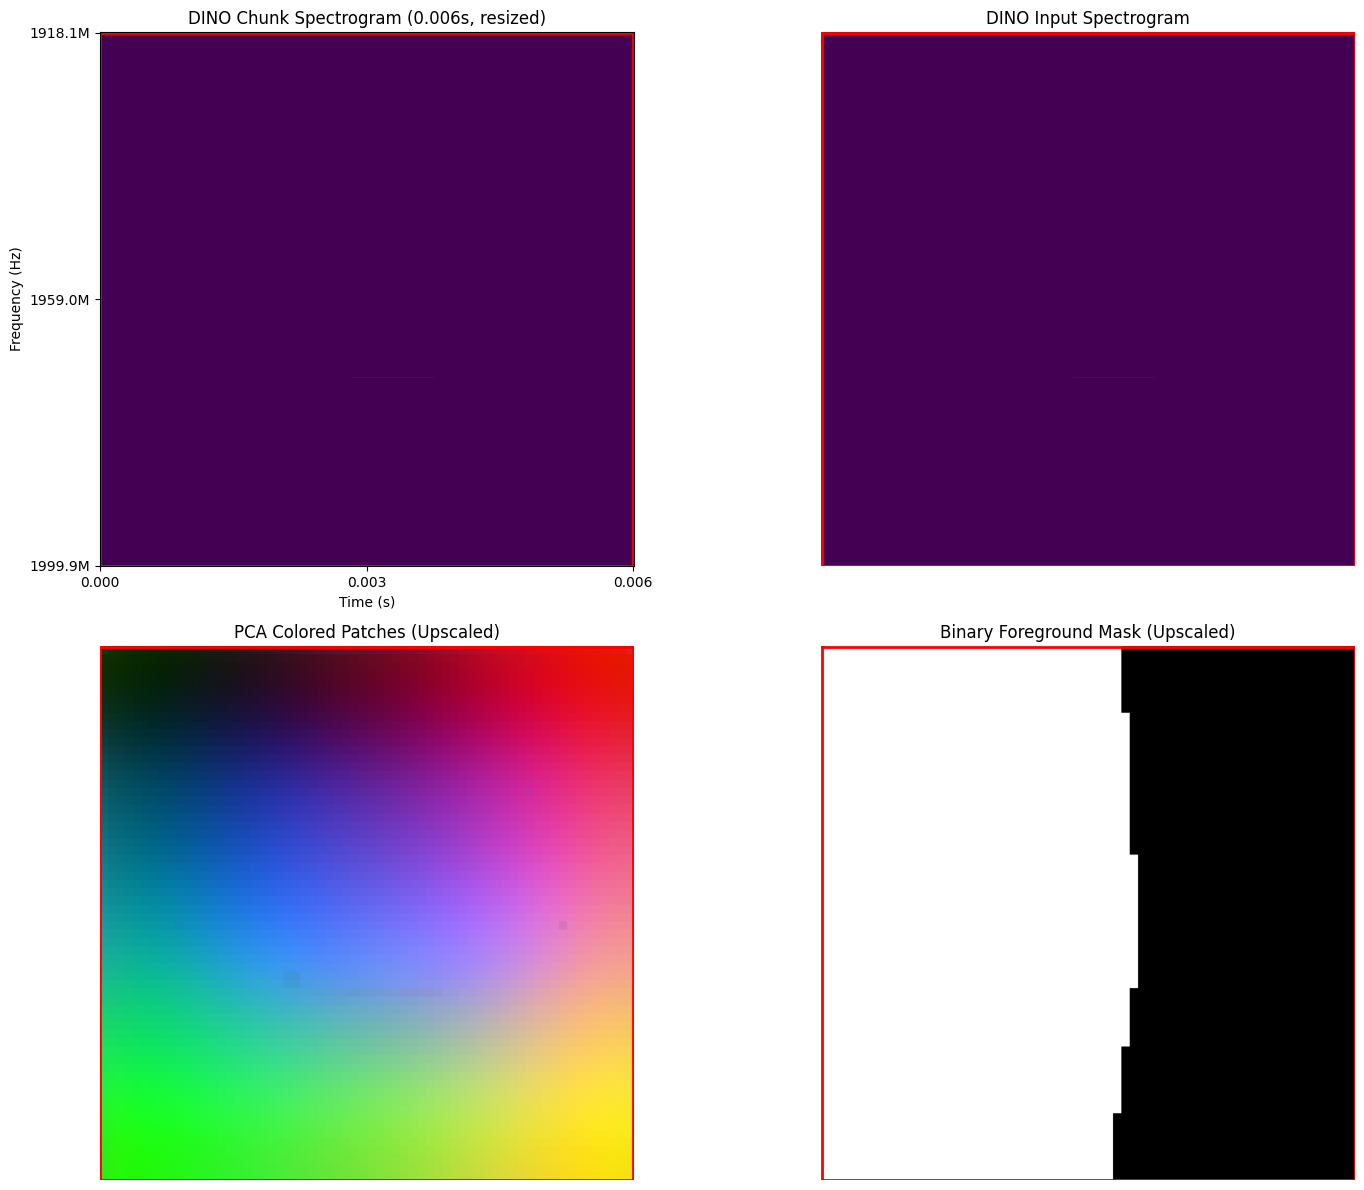

In [135]:
def _crop_for_plot(img):
    if 'plot_crop_box' in globals() and plot_crop_box:
        return img.crop(plot_crop_box)
    return img

# Compute PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)

# Normalize to 0-255
pca_features = (pca_features - pca_features.min(axis=0)) / (pca_features.max(axis=0) - pca_features.min(axis=0)) * 255
pca_features = pca_features.astype(np.uint8)

# Reshape to image grid
h, w = resized_img.size[1] // PATCH_SIZE, resized_img.size[0] // PATCH_SIZE
pca_img = pca_features.reshape(h, w, 3)

# Upscale PCA image to match resized_img size for alignment
from PIL import Image
pca_pil = Image.fromarray(pca_img.astype('uint8'))
pca_upscaled = pca_pil.resize(resized_img.size, Image.NEAREST)  # Nearest for blocky look

# Create binary mask using K-means clustering on full features (2 clusters: foreground/background)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features)
print(f"Cluster sizes: {np.bincount(cluster_labels)}")
mask = cluster_labels.reshape(h, w).astype(np.uint8) * 255  # 0 or 255

# Upscale mask to match resized_img size
mask_pil = Image.fromarray(mask, mode='L')
mask_upscaled = mask_pil.resize(resized_img.size, Image.NEAREST)

# Print dimensions
print(f"Spectrogram shape: {dino_Sxx_db.shape}")
print(f"Resized img size: {resized_img.size}")
print(f"PCA upscaled size: {pca_upscaled.size}")
print(f"Mask upscaled size: {mask_upscaled.size}")

# Plot
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

x_ticks = [0, resized_img.size[0] // 2, resized_img.size[0] - 1]
y_ticks = [0, resized_img.size[1] // 2, resized_img.size[1] - 1]

ax[0,0].imshow(_crop_for_plot(dino_spec_resized), aspect='equal')
ax[0,0].set_title(f'DINO Chunk Spectrogram ({dino_chunk_seconds:.3f}s, resized)')
ax[0,0].set_xlabel('Time (s)')
ax[0,0].set_ylabel('Frequency (Hz)')
ax[0,0].set_xticks(x_ticks)
ax[0,0].set_xticklabels([
    f'{0:.3f}',
    f'{dino_chunk_seconds / 2:.3f}',
    f'{dino_chunk_seconds:.3f}'
])
ax[0,0].set_yticks(y_ticks)
ax[0,0].set_yticklabels([
    f'{dino_f.min()/1e6:.1f}M',
    f'{(dino_f.min() + dino_f.max())/2e6:.1f}M',
    f'{dino_f.max()/1e6:.1f}M'
])
ax[0,0].axhline(y=0, color='red', linewidth=2)
ax[0,0].axhline(y=resized_img.size[1] - 1, color='red', linewidth=2)
ax[0,0].axvline(x=0, color='red', linewidth=2)
ax[0,0].axvline(x=resized_img.size[0] - 1, color='red', linewidth=2)

ax[0,1].imshow(_crop_for_plot(resized_img), aspect='equal')
ax[0,1].set_title('DINO Input Spectrogram')
ax[0,1].axhline(y=0, color='red', linewidth=2)
ax[0,1].axhline(y=resized_img.size[1] - 1, color='red', linewidth=2)
ax[0,1].axvline(x=0, color='red', linewidth=2)
ax[0,1].axvline(x=resized_img.size[0] - 1, color='red', linewidth=2)
ax[0,1].axis('off')

ax[1,0].imshow(_crop_for_plot(pca_upscaled), aspect='equal')
ax[1,0].set_title('PCA Colored Patches (Upscaled)')
ax[1,0].axhline(y=0, color='red', linewidth=2)
ax[1,0].axhline(y=resized_img.size[1] - 1, color='red', linewidth=2)
ax[1,0].axvline(x=0, color='red', linewidth=2)
ax[1,0].axvline(x=resized_img.size[0] - 1, color='red', linewidth=2)
ax[1,0].axis('off')

ax[1,1].imshow(_crop_for_plot(mask_upscaled), aspect='equal', cmap='gray')
ax[1,1].set_title('Binary Foreground Mask (Upscaled)')
ax[1,1].axhline(y=0, color='red', linewidth=2)
ax[1,1].axhline(y=resized_img.size[1] - 1, color='red', linewidth=2)
ax[1,1].axvline(x=0, color='red', linewidth=2)
ax[1,1].axvline(x=resized_img.size[0] - 1, color='red', linewidth=2)
ax[1,1].axis('off')

plt.tight_layout()
plt.show()



Quadrant colors after local centering:
top_left: [207.38671875 145.87304688 160.04882812]
top_right: [207.24121094 146.04003906 160.38769531]
bottom_left: [207.28125    146.65722656 160.03710938]
bottom_right: [207.1953125  146.80957031 160.47265625]

PCA variance explained - Original: [0.28212428 0.22951823 0.12734975]
PCA variance explained - Local Centered: [0.37590608 0.10490199 0.07011816]


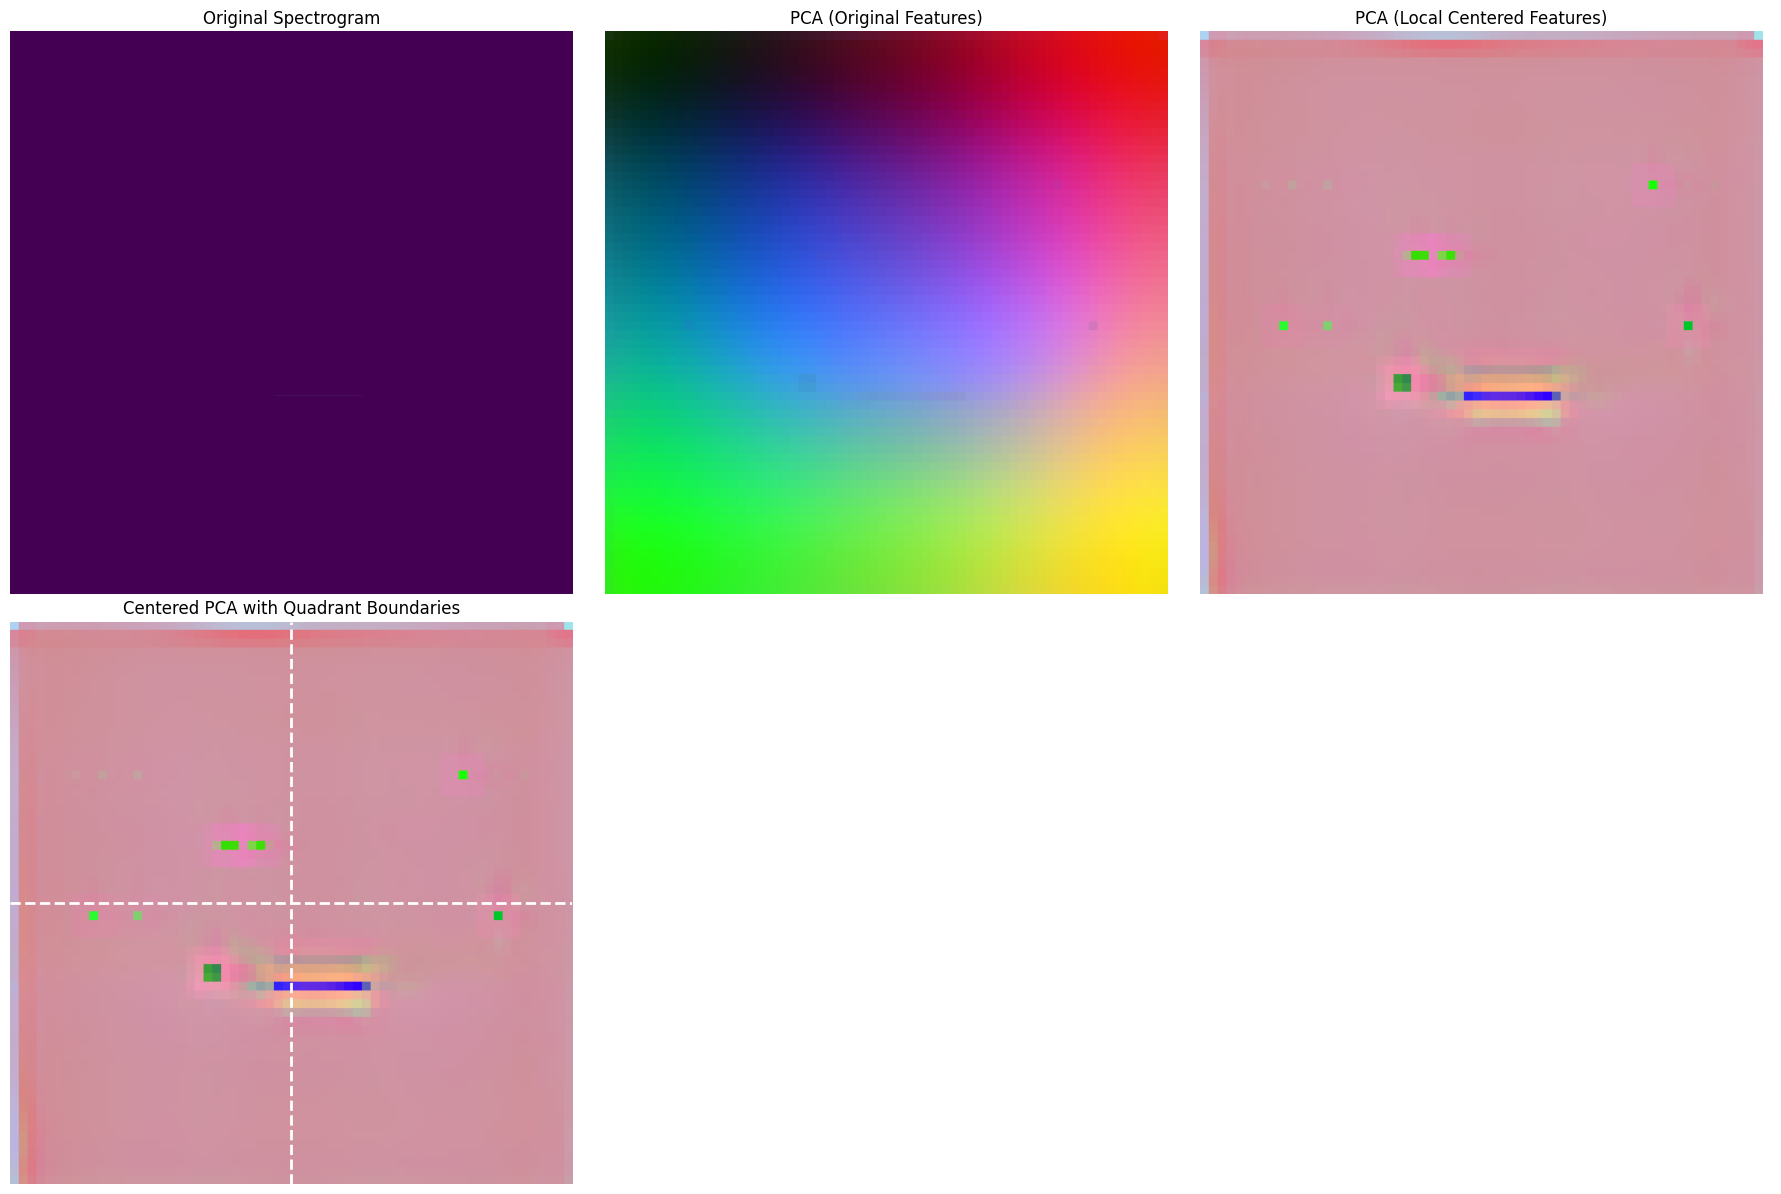

In [136]:
def _crop_for_plot(img):
    if 'plot_crop_box' in globals() and plot_crop_box:
        return img.crop(plot_crop_box)
    return img

# Alternative PCA computation with reduced spatial bias
# Method 1: Center features to reduce global positional effects
features_centered = features - np.mean(features, axis=0)

# Method 2: Local centering within spatial neighborhoods (optional)
def local_center_features(features, h, w, neighborhood_size=3):
    """Center features using local spatial neighborhoods to reduce positional bias."""
    features_reshaped = features.reshape(h, w, -1)
    centered = np.zeros_like(features_reshaped)

    pad = neighborhood_size // 2
    padded = np.pad(features_reshaped, ((pad, pad), (pad, pad), (0, 0)), mode='edge')

    for i in range(h):
        for j in range(w):
            neighborhood = padded[i:i+neighborhood_size, j:j+neighborhood_size, :]
            local_mean = np.mean(neighborhood.reshape(-1, features.shape[1]), axis=0)
            centered[i, j, :] = features_reshaped[i, j, :] - local_mean

    return centered.reshape(features.shape)

# Choose which centering method to use
use_local_centering = True  # Set to True for local centering, False for global centering

if use_local_centering:
    features_processed = local_center_features(features, h, w, neighborhood_size=5)
    centering_method = "local"
else:
    features_processed = features_centered
    centering_method = "global"

# Compute PCA on processed features
pca_centered = PCA(n_components=3)
pca_features_centered = pca_centered.fit_transform(features_processed)

# Normalize to 0-255
pca_features_centered = (pca_features_centered - pca_features_centered.min(axis=0)) / (pca_features_centered.max(axis=0) - pca_features_centered.min(axis=0)) * 255
pca_features_centered = pca_features_centered.astype(np.uint8)

# Reshape and upscale
pca_img_centered = pca_features_centered.reshape(h, w, 3)
pca_pil_centered = Image.fromarray(pca_img_centered.astype('uint8'))
pca_upscaled_centered = pca_pil_centered.resize(resized_img.size, Image.NEAREST)

# Compare original vs centered PCA
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

ax[0,0].imshow(_crop_for_plot(dino_spec_resized), aspect='equal')
ax[0,0].set_title('Original Spectrogram')
ax[0,0].axis('off')

ax[0,1].imshow(_crop_for_plot(pca_upscaled), aspect='equal')
ax[0,1].set_title('PCA (Original Features)')
ax[0,1].axis('off')

ax[0,2].imshow(_crop_for_plot(pca_upscaled_centered), aspect='equal')
ax[0,2].set_title(f'PCA ({centering_method.capitalize()} Centered Features)')
ax[0,2].axis('off')

# Show quadrant analysis for centered version
ax[1,0].imshow(_crop_for_plot(pca_upscaled_centered))
ax[1,0].set_title(f'Centered PCA with Quadrant Boundaries')
ax[1,0].axhline(y=resized_img.size[1]//2, color='white', linewidth=2, linestyle='--')
ax[1,0].axvline(x=resized_img.size[0]//2, color='white', linewidth=2, linestyle='--')
ax[1,0].axis('off')

# Analyze quadrant colors for centered features
quadrant_colors_centered = {}
for i in range(h):
    for j in range(w):
        if i < h//2 and j < w//2:
            quadrant = 'top_left'
        elif i < h//2 and j >= w//2:
            quadrant = 'top_right'
        elif i >= h//2 and j < w//2:
            quadrant = 'bottom_left'
        else:
            quadrant = 'bottom_right'

        if quadrant not in quadrant_colors_centered:
            quadrant_colors_centered[quadrant] = []
        quadrant_colors_centered[quadrant].append(pca_features_centered[i*w + j])

print(f"\nQuadrant colors after {centering_method} centering:")
for quadrant, colors in quadrant_colors_centered.items():
    avg_color = np.mean(colors, axis=0)
    print(f"{quadrant}: {avg_color}")

# Show difference in variance explained
print(f"\nPCA variance explained - Original: {pca.explained_variance_ratio_[:3]}")
print(f"PCA variance explained - {centering_method.capitalize()} Centered: {pca_centered.explained_variance_ratio_[:3]}")

ax[1,1].axis('off')  # Empty subplot
ax[1,2].axis('off')  # Empty subplot

plt.tight_layout()
plt.show()


# Expected Results on Natural Images

Before applying DINOv3 to RF spectrograms, let's see how it performs on natural images of animals. We'll load some example images from CIFAR-10, extract DINOv3 features, compute PCA visualizations, and estimate foreground/background masks using K-means clustering.

In [137]:
"""
# Load CIFAR-10 and get example animal images
import torchvision.datasets as datasets
from PIL import Image

# Load CIFAR-10 test set
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True)

# Get one image per animal class: cat (3), dog (5), horse (7)
animal_classes = [3, 5, 7]
class_names = ["Cat", "Dog", "Horse"]

fig, axes = plt.subplots(len(animal_classes), 3, figsize=(12, 4 * len(animal_classes)))

for i, cls in enumerate(animal_classes):
    # Find first image of this class
    idx = next(j for j, label in enumerate(test_dataset.targets) if label == cls)
    img, _ = test_dataset[idx]
    
    # Resize to match our spectrogram size (768x400)
    img_resized = img.resize((768, 400), Image.LANCZOS)
    
    # Extract DINOv3 features
    img_tensor = transform(img_resized).unsqueeze(0).cuda()
    with torch.no_grad():
        features = model.get_intermediate_layers(img_tensor, n=1, reshape=True, norm=True)[0]
        features = features.squeeze().view(features.shape[1], -1).permute(1, 0).cpu().numpy()
    
    # Compute PCA
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(features)
    pca_features = (pca_features - pca_features.min(axis=0)) / (pca_features.max(axis=0) - pca_features.min(axis=0)) * 255
    pca_features = pca_features.astype(np.uint8)
    
    # Reshape to image grid
    h, w = 400 // PATCH_SIZE, 768 // PATCH_SIZE
    pca_img = pca_features.reshape(h, w, 3)
    pca_pil = Image.fromarray(pca_img)
    pca_upscaled = pca_pil.resize((768, 400), Image.NEAREST)
    
    # Create mask using K-means on full features
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features)
    mask = cluster_labels.reshape(h, w).astype(np.uint8) * 255
    mask_pil = Image.fromarray(mask, mode="L")
    mask_upscaled = mask_pil.resize((768, 400), Image.NEAREST)
    
    # Plot
    axes[i, 0].imshow(img_resized)
    axes[i, 0].set_title(f"{class_names[i]} Image")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(pca_upscaled)
    axes[i, 1].set_title("PCA Patches")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(mask_upscaled, cmap="gray")
    axes[i, 2].set_title("Foreground Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()
"""

'\n# Load CIFAR-10 and get example animal images\nimport torchvision.datasets as datasets\nfrom PIL import Image\n\n# Load CIFAR-10 test set\ntest_dataset = datasets.CIFAR10(root="./data", train=False, download=True)\n\n# Get one image per animal class: cat (3), dog (5), horse (7)\nanimal_classes = [3, 5, 7]\nclass_names = ["Cat", "Dog", "Horse"]\n\nfig, axes = plt.subplots(len(animal_classes), 3, figsize=(12, 4 * len(animal_classes)))\n\nfor i, cls in enumerate(animal_classes):\n    # Find first image of this class\n    idx = next(j for j, label in enumerate(test_dataset.targets) if label == cls)\n    img, _ = test_dataset[idx]\n\n    # Resize to match our spectrogram size (768x400)\n    img_resized = img.resize((768, 400), Image.LANCZOS)\n\n    # Extract DINOv3 features\n    img_tensor = transform(img_resized).unsqueeze(0).cuda()\n    with torch.no_grad():\n        features = model.get_intermediate_layers(img_tensor, n=1, reshape=True, norm=True)[0]\n        features = features.squee

/tmp/ipykernel_418755/3524320182.py:28: RuntimeWarning: Mean of empty slice
  out_power = patch_power_norm[mask == 0].mean()
/home/trudes/Projects/Dinov3-RF-Signal-Detection/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Mask scores (power_contrast higher is better, area is fraction of patches):
kmeans: power_contrast=0.466, area=0.006
gmm: power_contrast=0.466, area=0.006
power_weighted_kmeans: power_contrast=0.487, area=0.005
edge_boxes: power_contrast=nan, area=1.000


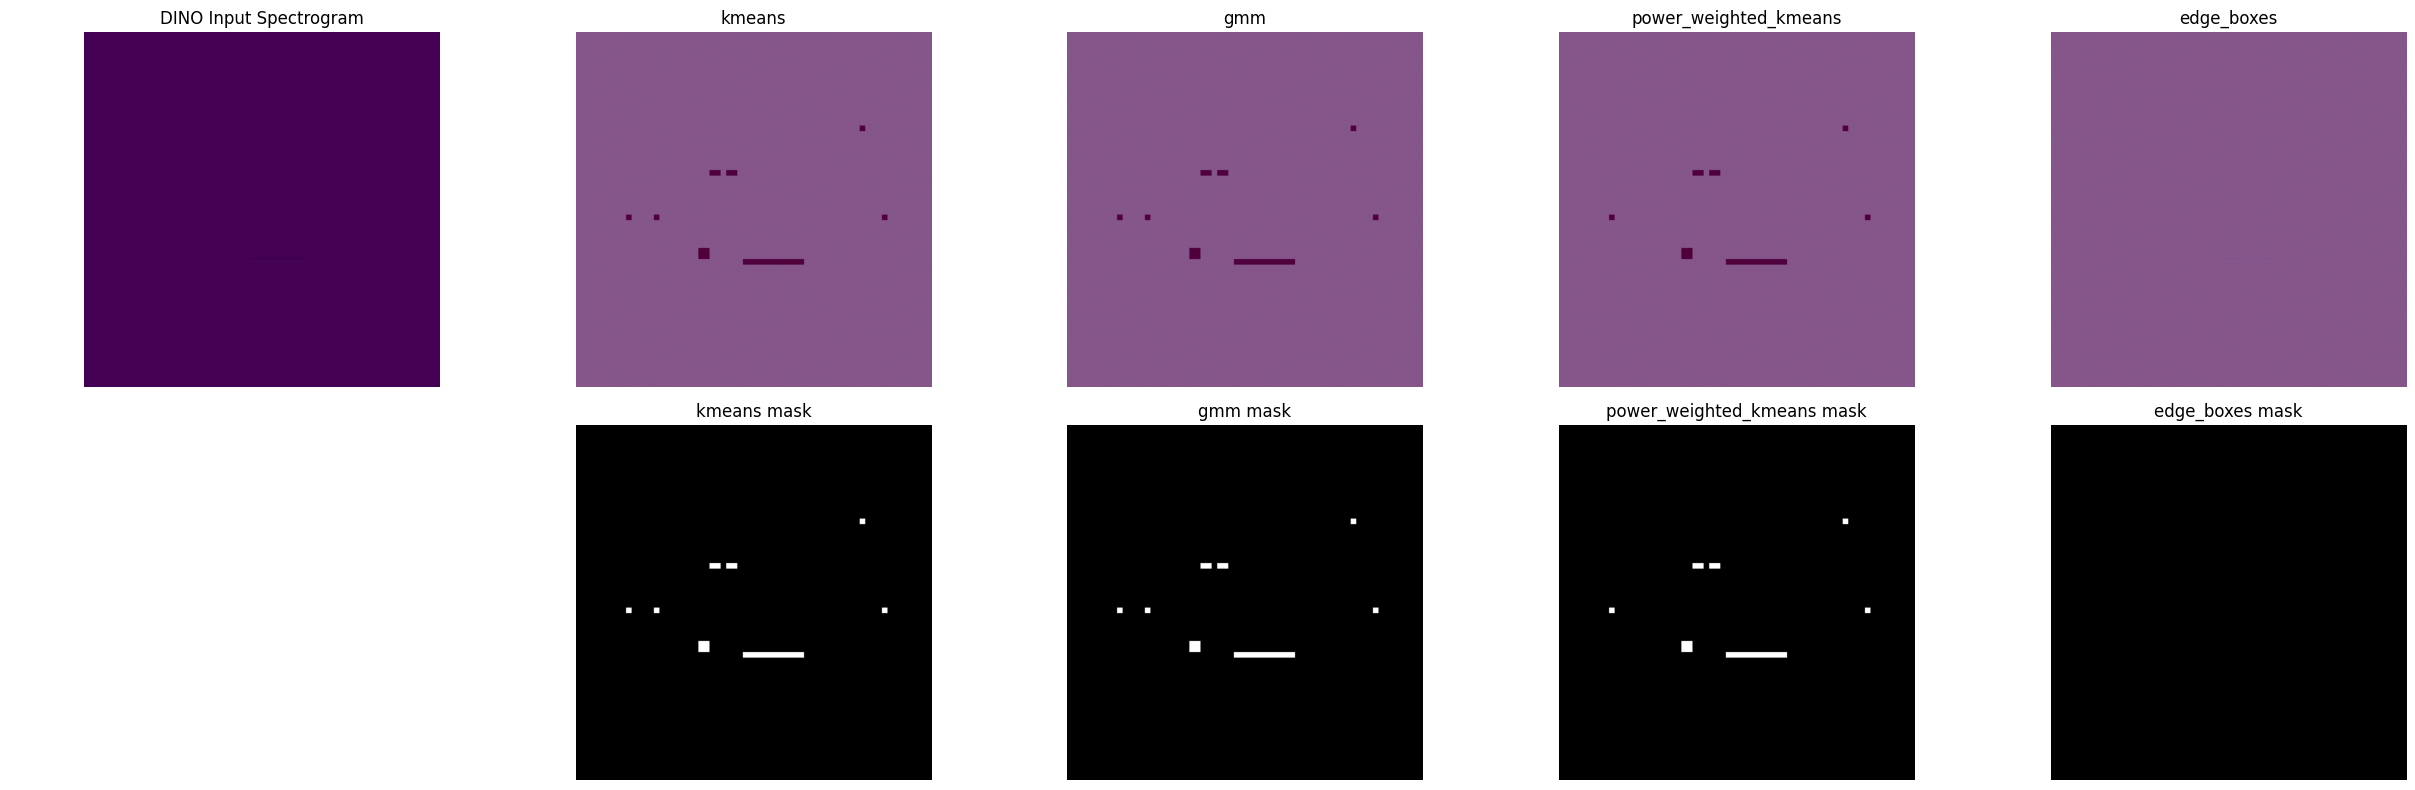

In [138]:
def _crop_for_plot(img):
    if 'plot_crop_box' in globals() and plot_crop_box:
        return img.crop(plot_crop_box)
    return img

# Mask quality experiments (patch-level)
features_for_masks = features_processed  # use centered features

from sklearn.mixture import GaussianMixture

# Build a patch-level power map aligned with resized_img
power_img = Image.fromarray(
    ((dino_Sxx_db - dino_Sxx_db.min()) / (dino_Sxx_db.max() - dino_Sxx_db.min()) * 255).astype(np.uint8)
)
# Resize to match DINO input, then downsample to patch grid
power_resized = power_img.resize(resized_img.size, Image.BILINEAR)
patch_power = np.array(power_resized.resize((w, h), Image.BILINEAR), dtype=np.float32)

# Normalize power map for scoring
patch_power_norm = (patch_power - patch_power.min()) / (patch_power.max() - patch_power.min() + 1e-8)


def score_mask(mask_flat, patch_power_norm):
    mask = mask_flat.reshape(h, w)
    if mask.sum() == 0:
        return {"power_contrast": 0.0, "area": 0.0}
    in_power = patch_power_norm[mask > 0].mean()
    out_power = patch_power_norm[mask == 0].mean()
    return {
        "power_contrast": float(in_power - out_power),
        "area": float(mask.mean()),
    }


def mask_from_kmeans(features, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features)
    counts = np.bincount(labels)
    signal_cluster = np.argmin(counts)
    return (labels == signal_cluster).astype(np.uint8)


def mask_from_gmm(features, n_components=2):
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    labels = gmm.fit_predict(features)
    counts = np.bincount(labels)
    signal_cluster = np.argmin(counts)
    return (labels == signal_cluster).astype(np.uint8)


def mask_from_power_weighted_kmeans(features, patch_power_norm, n_clusters=2, power_weight=1.0):
    # Append a single power feature to bias clustering toward energetic regions
    power_feat = patch_power_norm.reshape(-1, 1) * power_weight
    features_aug = np.concatenate([features, power_feat], axis=1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(features_aug)
    counts = np.bincount(labels)
    signal_cluster = np.argmin(counts)
    return (labels == signal_cluster).astype(np.uint8)


def mask_from_edge_boxes(patch_power_norm, edge_percentile=95):
    # Edge detection on patch power map, then bounding boxes from connected edges
    from scipy import ndimage
    sx = ndimage.sobel(patch_power_norm, axis=1, mode='nearest')
    sy = ndimage.sobel(patch_power_norm, axis=0, mode='nearest')
    edges = np.hypot(sx, sy)
    thresh = np.percentile(edges, edge_percentile)
    edge_mask = edges >= thresh
    labeled, num = ndimage.label(edge_mask)
    box_mask = np.zeros_like(edge_mask, dtype=np.uint8)
    if num == 0:
        return box_mask.reshape(-1)
    slices = ndimage.find_objects(labeled)
    for slc in slices:
        if slc is None:
            continue
        y0, y1 = slc[0].start, slc[0].stop
        x0, x1 = slc[1].start, slc[1].stop
        box_mask[y0:y1, x0:x1] = 1
    return box_mask.reshape(-1)


methods = {
    "kmeans": mask_from_kmeans(features_for_masks),
    "gmm": mask_from_gmm(features_for_masks),
    "power_weighted_kmeans": mask_from_power_weighted_kmeans(features_for_masks, patch_power_norm, power_weight=4.0),
    "edge_boxes": mask_from_edge_boxes(patch_power_norm, edge_percentile=90),
}

# Score masks
scores = {}
for name, mask_flat in methods.items():
    scores[name] = score_mask(mask_flat, patch_power_norm)

print('Mask scores (power_contrast higher is better, area is fraction of patches):')
for name, s in scores.items():
    print(f"{name}: power_contrast={s['power_contrast']:.3f}, area={s['area']:.3f}")

# Visualize masks (overlay + mask-only)
fig, axes = plt.subplots(2, len(methods) + 1, figsize=(5 * (len(methods) + 1), 8))
axes[0, 0].imshow(_crop_for_plot(dino_spec_resized))
axes[0, 0].set_title('DINO Input Spectrogram')
axes[0, 0].axis('off')
axes[1, 0].axis('off')

for col, (name, mask_flat) in enumerate(methods.items(), start=1):
    mask_img = (mask_flat.reshape(h, w) * 255).astype(np.uint8)
    mask_pil = Image.fromarray(mask_img, mode='L')
    mask_upscaled = mask_pil.resize(resized_img.size, Image.NEAREST)

    axes[0, col].imshow(_crop_for_plot(dino_spec_resized))
    axes[0, col].imshow(_crop_for_plot(mask_upscaled), alpha=0.35, cmap='Reds')
    axes[0, col].set_title(name)
    axes[0, col].axis('off')

    axes[1, col].imshow(_crop_for_plot(mask_upscaled), cmap='gray')
    axes[1, col].set_title(f'{name} mask')
    axes[1, col].axis('off')

plt.tight_layout()
plt.show()
